In [171]:
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import SkyCoord
from astropy.io import ascii
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from math import *
from math import log10
import sep 

In [84]:
def match_radec(filename, catalname):
    
    catal=ascii.read(catalname)
    ra = catal['raMean']
    dec = catal['decMean']
    inflag = catal['objInfoFlag']
    qflag = catal['qualityFlag']
    c = SkyCoord(ra, dec, frame='icrs', unit='deg')

    ob = ascii.read(filename)    
    ALPHA_J2000 = ob['ALPHA_J2000']
    DELTA_J2000 = ob['DELTA_J2000']
    flag = ob['FLAGS']
    o = SkyCoord(ALPHA_J2000, DELTA_J2000, frame='icrs', unit='deg')

    indx, sep, _ = o.match_to_catalog_sky(c)
    return sep, c, o, flag, inflag, qflag, ob, catal, indx
        

In [85]:
def flagging(sep_limit, sep, c, o, flag, inflag, qflag):
    #seperation and flag restriction 
    P=[]
    #sep_limit=2

    for i in range(len(o)):
        if sep.arcsec[i]<sep_limit:
            if flag[i]<1:
                if inflag[i] < 10**9:
                    if qflag[i] < 100:
                        P.append(i)
        
    print(P)
    return P

In [900]:
def zeropoint(P, ob, catal, indx):
    mag_ob = np.array(ob['MAG_APER'])
    mag_catal = np.array(catal['R'])
    magErr = np.array(ob['MAGERR_APER'])
    gErr = np.array(catal['gMeanKronMagErr'])
    rErr = np.array(catal['rMeanKronMagErr'])
    FWHM = np.array(ob['FWHM_IMAGE'])

    #zero point & zero point error calculation 
    zp = []
    zpE = []
    for i in range(len(mag_ob)):
        u=indx[i]
        x = float(mag_catal[u])-float(mag_ob[i])
        e = np.sqrt(magErr[i]**2 + gErr[u]**2 + rErr[u]**2)
        zp.append(x)
        zpE.append(e)
    
    print(FWHM)
    #zp versus ref mag
    mag_c_new=[]
    zp_new=[]
    zpE_new=[]
    seeing=[]
    for i in P:
        u=indx[i]
        if 27>zp[i]:
            if zpE[i]<0.1:
                if 17.5>mag_catal[u]>13:
                    if FWHM[i]*0.4454<4:
                        mag_c_new.append(mag_catal[u])
                        zpE_new.append(zpE[i])
                        zp_new.append(zp[i])
                        seeing.append(0.4454*FWHM[i])
    
    return zp_new, zpE_new, mag_c_new, seeing
        
        

In [751]:
def depth(ob, zp_new, seeing, name, image_file):
    import sep
    
    Me = ob['MAGERR_APER']
    M = ob['MAG_APER']
    

    #image_data=fits.open('/data3/yunyi/SOAO/fitsfiles/M101_20210604/Calib-SOAO-M101-20210604-153827-R-60.fits')
    #header=image_data[0].header
    #zp= header['ZP_0']
    zp=np.mean(zp_new)
    
    data = fits.getdata(image_file,ext=0)
    data = data.byteswap().newbyteorder()
    bkg=sep.Background(data, bw=512, bh=512)
    
    N=5
    std = bkg.globalrms
    slv = bkg.globalback
    r=np.mean(seeing)
    dp=zp - 2.5*log10(N*std*np.sqrt(np.pi*(r**2)))

    print('analytical depth is %f'%dp)
    print('seeing is %f'%r)
    
    
    mag_list=[]
    mag_list.append(Me)
    mag_list.append(M)
    
    pilist=[]
    pjlist=[]
    for i in range(len(M)):
        p=abs(0.2-mag_list[0][i])
        if p<0.01:
            pilist.append(mag_list[0][i])
            pjlist.append(mag_list[1][i])
            
    mag_list_new = []
    mag_list_new.append(pilist)
    mag_list_new.append(pjlist)

    pj = max(pjlist)+zp
    print(mag_list_new)
    for i in range(len(pilist)):
        if mag_list_new[1][i]+zp == pj:
            pi = mag_list_new[0][i]
     
            
    print('mag error is %f'%pi)
    plt.figure(figsize=(10,7))
    plt.plot(M+zp, Me, 'o', alpha=0.6)
    plt.plot([12, pj], [pi, pi], color='orange')
    plt.plot([pj,pj], [pi,0], color='orange')
    plt.scatter(pj, pi, s= 100, c='r')
    plt.text(pj, pi, '{:.5f}'. format(pj), size=15)
    plt.title(name)
    plt.xlabel('MAG')
    plt.ylabel('MAG ERROR')
    plt.show()

    print('mag is %f'%pj)

    
    return std, slv, r, dp

In [1035]:
sep, c, o, flag, inflag, qflag, ob, catal, indx=match_radec('/data3/yunyi/SOAO/code/NGC0628_median.cat',
                                                            '/data3/yunyi/SOAO/code/NGC0628_R.csv')

In [1036]:
len(sep.arcsec)

241

In [1037]:
y=[x for x in sep.arcsec if x<0.5]
len(y)

135

In [1038]:
sep_limit=0.5

In [1039]:
P=flagging(sep_limit, sep, c, o, flag, inflag, qflag)

[11, 16, 19, 20, 21, 23, 25, 26, 27, 28, 31, 33, 36, 37, 44, 46, 55, 56, 57, 58, 59, 63, 64, 65, 67, 70, 73, 76, 79, 80, 82, 84, 90, 91, 92, 93, 95, 97, 99, 101, 105, 109, 113, 116, 117, 119, 124, 126, 134, 136, 137, 138, 139, 142, 143, 144, 147, 149, 160, 162, 168, 170, 173, 175, 176, 180, 182, 183, 184, 185, 187, 188, 189, 194, 196, 200, 204, 207, 208, 209, 212, 213, 215, 217, 218, 220, 221, 222, 223, 224, 227, 228, 233, 235, 237, 238]


In [1040]:
print(P)

[11, 16, 19, 20, 21, 23, 25, 26, 27, 28, 31, 33, 36, 37, 44, 46, 55, 56, 57, 58, 59, 63, 64, 65, 67, 70, 73, 76, 79, 80, 82, 84, 90, 91, 92, 93, 95, 97, 99, 101, 105, 109, 113, 116, 117, 119, 124, 126, 134, 136, 137, 138, 139, 142, 143, 144, 147, 149, 160, 162, 168, 170, 173, 175, 176, 180, 182, 183, 184, 185, 187, 188, 189, 194, 196, 200, 204, 207, 208, 209, 212, 213, 215, 217, 218, 220, 221, 222, 223, 224, 227, 228, 233, 235, 237, 238]


In [1041]:
zp_new, zpE_new, mag_c_new, seeing =zeropoint(P, ob, catal, indx)

[ 5.21  4.06  6.62  5.34  3.77  8.69  3.98  5.93  5.05  4.64  7.52  5.13
  4.47  3.91  3.88  3.92  5.93 35.07  5.17  7.29  7.2   4.49  5.61  5.01
  5.29  3.78  3.69  3.82  4.62  4.54 21.18  9.88 14.49  3.72 11.42 16.42
  3.72  3.02  8.62 12.28 12.15  5.35  6.88 17.72  4.23  5.69  3.79  6.58
 11.8   9.94  3.44  1.99  8.35  8.45 11.03  4.32  6.05 10.01  7.45  5.18
 12.69  4.89  4.22 10.52  2.81  3.98 11.1   7.82 10.4   8.91  4.91  3.8
 14.58  9.    3.88  6.6   5.49  6.26  8.51  7.01  3.83  2.59  3.77  9.08
  4.12  5.16 13.49 14.51 16.25  3.96  3.79  2.58  5.17  3.75  6.79  5.58
 11.89  4.18 14.19  5.76  6.16  4.76 15.51  9.43  7.47  3.74  9.91  9.7
 17.61  5.82  3.4  18.22  4.08  6.11 15.08 15.83  5.73  3.18 17.54  6.39
 15.35  7.67  2.3  10.77  8.18  3.86  5.58  3.66  3.86  3.45  7.91  6.04
  8.18  7.27  3.76  3.75  3.75  8.46  3.8   5.89  5.75 16.48  8.92  7.79
  4.43  8.32  9.42  3.74  9.05  3.93  5.58  4.77  4.89  6.47  4.19 15.91
  3.84  4.55  5.12  3.47  8.53  7.09  2.85  7.82  8.1

In [1042]:
seeing

[3.246966,
 1.6836119999999999,
 1.643526,
 1.701428,
 1.6568880000000001,
 1.6568880000000001,
 1.688066,
 1.9241280000000003,
 1.7726920000000002,
 1.6791580000000002,
 1.688066,
 1.67025,
 1.67025,
 1.973122,
 1.665796,
 1.7504220000000001,
 3.068806,
 1.674704,
 1.786054,
 1.7949620000000002,
 3.3583160000000003,
 1.701428,
 1.69252,
 1.67025,
 1.701428]

In [1043]:
np.mean(seeing)

1.90078904

In [1044]:
np.std(zp_new)

0.2664478322985731

In [1045]:
np.mean(zp_new)

25.475504704

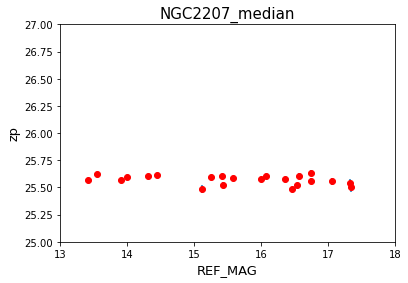

<Figure size 2160x2160 with 0 Axes>

In [1046]:
#zp versus mag plotting 
plt.plot(mag_c_new, zp_new, 'ro')
plt.axis([13, 18, 25, 27])
plt.title('NGC2207_median', fontsize=15)
plt.xlabel('REF_MAG', fontsize=13)
plt.ylabel('zp', fontsize=13)
plt.errorbar(mag_c_new, zp_new, yerr=zpE_new, linestyle="None")
plt.figure(figsize=(30, 30))
plt.show()

analytical depth is 20.592232
seeing is 1.900789
[[0.2075, 0.2025, 0.1994, 0.1957, 0.2034, 0.1958, 0.2059], [-5.9165, -5.9456, -5.9618, -5.9812, -5.9373, -5.9788, -5.9248]]
mag error is 0.207500


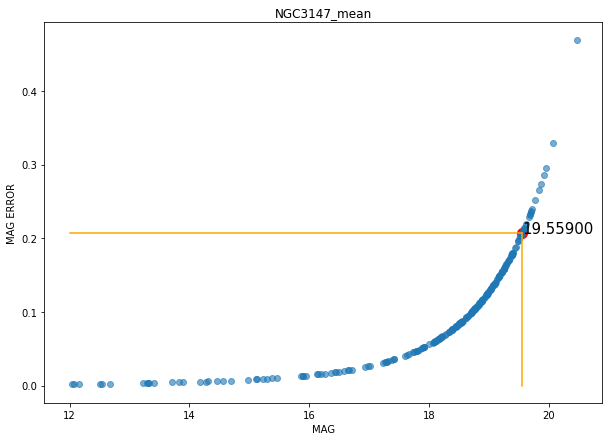

mag is 19.559005


In [1047]:
std, slv, r, dp=depth(ob, zp_new, seeing, 'NGC3147_mean', '/data3/yunyi/SOAO/NGC0628_median.fits')

In [1048]:
slv

86.16641235351562

In [1049]:
fits_file = '/data3/yunyi/SOAO/referenceimage/Ref-NGC0628-R-540.com.fits'
with fits.open(fits_file, 'update') as f:
    for hdu in f:
        hdu.header['COMATHR'] = 'Yunyi Choi'
        hdu.header['SEEING'] = r
        hdu.header['UL5_2'] = dp
        hdu.header['SKYSIG'] = std
        hdu.header['SKYVAL'] = slv
        print(hdu.header)

SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 2048 / Axis length                                    NAXIS2  =                 2048 / Axis length                                    EXTEND  =                    F / File may contain extensions                    ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        DATE    = '2021-08-26T02:58:01' / Date FITS file was generated                  IRAF-TLM= '2021-08-26T02:57:58' / Time of last modification                     OBSERVAT= 'SOAO         '      /observatory                                     TELESCOP= '61cm, f/3.5'        /telescope                                       INSTRUME= 'FLI4K'              /instrument                                      OBSERVER= 'hanky'              /observer

In [ ]:
======================================================================

In [724]:
len(o[flag<1])


287

In [765]:
qflag[26791]

32

In [604]:
len(c[indx[sep.arcsec<0.1]])

1

In [436]:
sep.arcmin

array([2.43911095e-02, 9.50302700e-03, 2.76425543e-01, 5.77963313e-03,
       2.26619416e-01, 4.48341692e-03, 6.06463461e-03, 5.96160838e-03,
       1.93769289e-01, 3.52196846e-03, 2.09783130e-01, 2.70047003e-01,
       2.14318652e-02, 1.77738507e-01, 5.44151658e-03, 8.25531282e-02,
       2.71452005e-01, 9.91097496e-03, 6.86742941e-03, 4.21117622e-03,
       8.72731400e-03, 7.67166425e-03, 3.95784851e-03, 3.78158584e-03,
       3.19133489e-03, 2.63665092e-03, 2.66418516e-01, 1.03043000e-02,
       1.94980931e-01, 1.92501301e-02, 2.48457031e-01, 2.05113195e-01,
       5.03275047e-03, 2.47427013e-01, 9.37715910e-03, 3.69494060e-02,
       2.17194446e-01, 4.51062372e-03, 8.56545953e-03, 6.85347337e-02,
       1.38971588e-02, 1.60304898e-02, 4.84450931e-03, 9.28693238e-03,
       4.74755288e-03, 6.99742070e-03, 8.43219130e-03, 6.84609847e-03,
       5.01782254e-03, 1.06601505e-02, 4.33535350e-03, 9.89499700e-02,
       1.19206836e-02, 1.88494376e-02, 6.27686205e-03, 7.94731672e-02,
      

In [1004]:
#seperation and flag restriction 
P=[]
sep_limit=2

for i in range(len(o)):
    if sep.arcsec[i]<sep_limit:
        if flag[i]<1:
            if inflag[i] < 10**9:
                if qflag[i] < 100:
                    P.append(i)
        
print(P)

[2, 6, 9, 10, 11, 13, 14, 20, 22, 23, 26, 28, 32, 33, 34, 38, 39, 41, 43, 44, 49, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 65, 66, 67, 69, 70, 80, 84, 85, 91, 94, 96, 101, 102, 105, 109, 112, 113, 119, 120, 121, 124, 126]


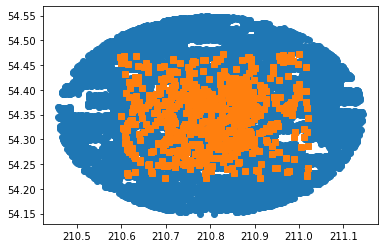

In [891]:
plt.plot(c.ra, c.dec, linestyle='none', marker='o')
plt.plot(o.ra, o.dec, linestyle='none', marker='s')

In [752]:
o[43]

<SkyCoord (ICRS): (ra, dec) in deg
    (154.4616558, 73.4207011)>

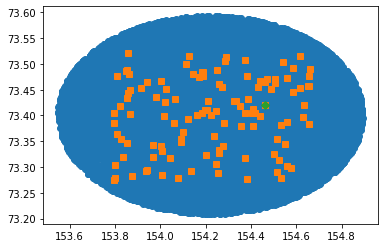

In [753]:
plt.plot(c.ra, c.dec, linestyle='none', marker='o')
plt.plot(o.ra, o.dec, linestyle='none', marker='s')
plt.plot(o[43].ra, o[43].dec, linestyle='none', marker='D')


In [1005]:
mag_ob = np.array(ob['MAG_AUTO'])
mag_catal = np.array(catal['R'])
magErr = np.array(ob['MAGERR_AUTO'])
gErr = np.array(catal['gMeanKronMagErr'])
rErr = np.array(catal['rMeanKronMagErr'])

#zero point & zero point error calculation 
zp = []
zpE = []
for i in range(len(mag_ob)):
    u=indx[i]
    x = float(mag_catal[u])-float(mag_ob[i])
    e = np.sqrt(magErr[i]**2 + gErr[u]**2 + rErr[u]**2)
    zp.append(x)
    zpE.append(e)


In [766]:
mag_catal[26791]

11.298774824142455

In [787]:
zp

[31.741428091430667,
 26.317736287689208,
 24.91175589828491,
 28.372193338775627,
 27.142487168884276,
 28.781725785064694,
 29.299031401824948,
 31.12602578506469,
 23.690787168884277,
 25.49083047904968,
 22.36441529006958,
 21.56231529006958,
 28.70372777175903,
 25.521487168884278,
 27.542925785064693,
 28.10942777175903,
 26.293082067108152,
 25.863075843811032,
 27.12482770614624,
 26.846741210937502,
 23.468680864715576,
 30.159433772277833,
 30.309868398284912,
 29.73301079559326,
 26.80241079559326,
 28.530461174774167,
 31.972332395172117,
 26.898126319122312,
 29.027148465728764,
 30.436959465026852,
 28.32459474105835,
 27.914838410949706,
 28.118283342742913,
 26.610926319122314,
 22.10891738204956,
 22.906534284210203,
 27.092590731811523,
 25.4227366065979,
 26.114659465026854,
 22.592452519607544,
 28.01506812362671,
 26.018894741058347,
 25.390530253601078,
 27.293259465026857,
 29.159068425750732,
 29.002985991668705,
 28.403613397216795,
 28.57593727264404,
 28.1772

In [751]:
zp.index(26.985674824142457)

43

In [ ]:
#zp versus mag auto
'''    
#weird zp exclusion 
mag_ob_new=[]
zp_new=[]
zpE_new=[]
for i in P:
    if 100>zp[i]>0:
        mag_ob_new.append(mag_ob[i])
        zpE_new.append(zpE[i])
        zp_new.append(zp[i])

print(zpE_new)
'''

In [1006]:
#zp versus ref mag
mag_c_new=[]
zp_new=[]
zpE_new=[]
for i in P:
    u=indx[i]
    if 27.5>zp[i]>0:
        if zpE[i]<0.1:
            if mag_catal[u]>13:
                mag_c_new.append(mag_catal[u])
                zpE_new.append(zpE[i])
                zp_new.append(zp[i])

In [799]:
sorted(zp_new, reverse=True)

[25.90211876602173,
 25.869587168884276,
 25.73985959663391,
 25.73936252212524,
 25.736913981628415,
 25.73210147628784,
 25.727378771209715,
 25.712458454132083,
 25.708452519607544,
 25.705651490783694,
 25.700417382049558,
 25.700284072494508,
 25.69411098213196,
 25.692275550460817,
 25.689869109344485,
 25.687173107910155,
 25.684004051971435,
 25.678932003021238,
 25.671578159332274,
 25.665370513916017,
 25.66445673904419,
 25.662105702590942,
 25.617634284210204,
 25.612210896301267,
 25.601415290069582,
 25.598224472808838,
 25.589015132904052,
 25.579293775177,
 25.578876210021974,
 25.567381464385985,
 25.555801674652095,
 25.530414373779294,
 25.517968859100343,
 25.51091719970703,
 25.47857155685425,
 25.469433319091795,
 25.46576298294067]

In [1007]:
np.mean(zp_new)
#np.mean(zpE_new)

25.65831312976028

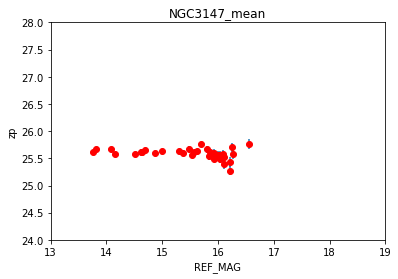

<Figure size 1080x1080 with 0 Axes>

In [966]:
#zp versus mag plotting 
plt.plot(mag_c_new, zp_new, 'ro')
plt.axis([13, 19, 24, 28])
plt.title('NGC3147_mean')
plt.xlabel('REF_MAG')
plt.ylabel('zp')
plt.errorbar(mag_c_new, zp_new, yerr=zpE_new, linestyle="None")
plt.figure(figsize=(15,15))
plt.show()

#error bar 




(array([ 1., 11., 31.,  7.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([25.2265593 , 25.40247085, 25.57838241, 25.75429396, 25.93020551,
        26.10611706, 26.28202862, 26.45794017, 26.63385172, 26.80976327,
        26.98567482]),
 <BarContainer object of 10 artists>)

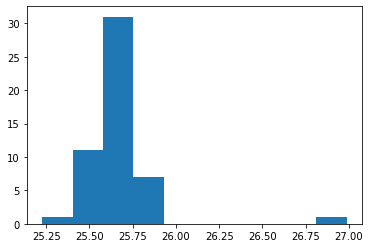

In [748]:
plt.hist(zp_new)

In [530]:
testa = [1,2,3]
testb = [4,5,6]
testc = []
testc.append(testa)
testc.append(testb)

In [531]:
testc


[[1, 2, 3], [4, 5, 6]]

In [535]:
testc[1][2]

6